In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from os.path import basename, isfile

In [24]:
# PATH = "Data/C17"
# CATALOGUE = "EPIC"
# files = sorted(glob(f"{PATH}/*.pow"))

# PATH = "TESS/"
# CATALOGUE="TIC"
# files = sorted(glob(f"{PATH}/*.txt"))

PATH = "Data/TESS/GI 11047/r1/spoc/"
CATALOGUE="TIC"
files = sorted(glob(f"{PATH}/*_psd_tot_nw.txt"))

# PATH = "Data/Dublicates/"
# CATALOGUE="EPIC"
# files = sorted(glob(f"{PATH}/*/*_psd_tot_nw.txt"))

In [27]:
# Δν_list = pd.read_csv(f"{PATH}/Δν", delim_whitespace=True, skiprows=1, names=['ID', 'Δν', 'ν_max'])
# Δν_list = pd.read_csv(f"{PATH}/Δν", delim_whitespace=False, skiprows=1, names=['ID', 'ν_max', 'e_ν_max', 'Δν', 'e_Δν'])
# Δν_list = pd.read_csv(f"{PATH}/Δν", delim_whitespace=False, skiprows=1, names=['ID', 'Δν', 'e_Δν', 'ν_max', 'e_νmax'])

df = pd.read_excel("Correspondence/TESS_results_excel.xlsx", skiprows=1)
df = df.rename(columns={df.columns[0]: 'ID', df.columns[-1]: 'flag'})

m = np.array([isinstance(i, str) and i[0] in ['Y', 'y'] for i in df['flag']])
Δν_list = df[m][['ID', 'numax', 'numax_error', 'dnu', 'dnu_error']].rename(columns={'numax': 'ν_max', 'dnu': 'Δν'})

files = [f"{PATH}/{int(_)}_psd_tot_nw.txt" for _ in Δν_list['ID']]

In [6]:
len(Δν_list)

23

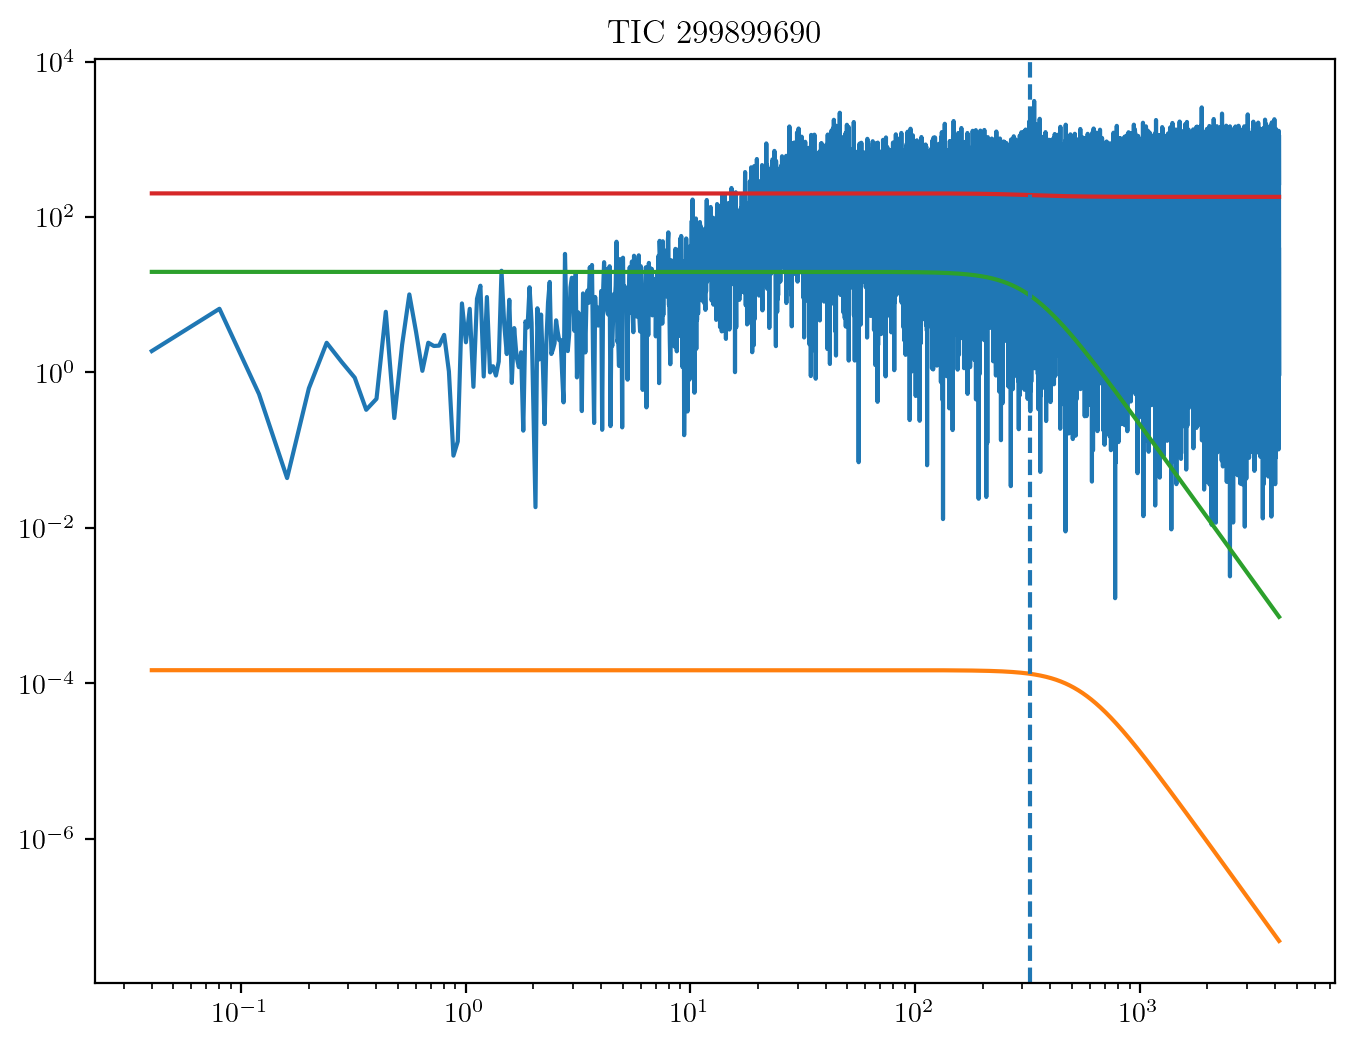

In [29]:
# file = files[0]
# # ID = int(file.split("kplr")[1].split("_")[0])
# ID = int(file.split("ktwo")[1].split("_")[0])
# # ID = int(basename(file).split('_')[0])
# r = Δν_list[Δν_list['ID'] == ID]

r = Δν_list.iloc[16]
ID = int(r['ID'])
# file = f"{PATH}/{ID}/{ID}_psd_tot.txt"
file = files[16]

Δν = float(r['Δν'])
νmax = float(r['ν_max'])
# df = pd.read_csv(file, delim_whitespace=True, skiprows=11, names=['ν','P'])
df = pd.read_csv(file, delim_whitespace=True, names=['ν','P1', 'P2', 'P'])

plt.close('all')
plt.plot(df['ν'], df['P'])
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
# plt.axvline(νmax, c='red')

# def Harvey(ν, t, g):
#     return np.power(10, t) / (1 + (ν/np.power(10, g))**2)

def Harvey(ν, A, ν0):
    return 2 * np.sqrt(2) / np.pi * A**2 / (ν0 * (1 + (ν / ν0)**4))

from scipy.optimize import least_squares

def model(q):
    p = q[1:]
    return q[0] + np.sum([Harvey(df.ν.values, *p[2*i:2*i+2]) for i in range(len(p)//2)], axis=0)

def cost(p):
    return (df.P.values - model(p))#/np.sqrt(df.P.values)

p0 = [0, 10, 100, 10, 500]
j = least_squares(cost, p0)

for i in range(len(p0[1:])//2):
    plt.plot(df['ν'].values, Harvey(df['ν'].values, *j['x'][2*i+1:2*i+3]))
plt.plot(df['ν'].values, model(j['x']))
plt.axvline(νmax, ls='dashed')
# plt.plot(df['ν'].values, model(session.bg[:-3]))
plt.title(f"{CATALOGUE} {ID}")
plt.show()

In [30]:
j['x']

array([ 1.81563157e+02, -3.02510490e-01,  5.60617466e+02,  8.40608287e+01,
        3.23500852e+02])

In [31]:
# from os.path import isfile
# if isfile(f"./Seed/{CATALOGUE}{ID}.pkl"):
#     seed = pd.read_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
#     for _ in seed.nu_med:
#         plt.axvline(_, c='grey', ls='dotted')

%matplotlib tk

plt.plot(df['ν'], df['P'])

plt.xlabel(r'$\nu$/$\mu$Hz')
plt.ylabel(r'PSD/ppm$^2$ $\mu$Hz$^{-1}$')
# plt.xlim(νmax - 10 * Δν, νmax + 10 * Δν)
# plt.gca().set_yscale('log')
plt.show()

# Mode identification

In [34]:
from scipy.ndimage import gaussian_filter1d, gaussian_filter

Δν = float(r['Δν'])
# Δν = 47.2
# Δν = 30
# Δν = 531.8 - 519.5
νmax = float(r['ν_max'])

# Δν = 145
# νmax = 3090

ε_ν = np.mean(np.diff(df['ν'])) # Grid spacing
w = int(Δν // ε_ν) # grid width in pixels
h = int(len(df) // w)

Δν_plot = ε_ν * w

cleaned = (df['P'].values - model(j['x']))
cleaned = gaussian_filter(cleaned, 3)

f = cleaned[:w*h].reshape(h, w)
m = (df.ν.values > (νmax-20*Δν))&(df.ν.values < (νmax+20*Δν))

plt.close('all')
plt.plot(df.ν.values[m], df.P.values[m], c='grey', alpha=.4)
plt.plot(df.ν.values[m], cleaned[m])
# plt.gca().set_yscale('log')
plt.xlabel(r'$\nu$/$\mu$Hz')
plt.ylabel(r'PSD/ppm$^2$ $\mu$Hz$^{-1}$')

# from os.path import isfile
# if isfile(f"./Seed/{CATALOGUE}{ID}.pkl"):
#     seed = pd.read_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
#     for _ in seed.nu_med:
#         plt.axvline(_, c='grey', ls='dotted')
# # plt.ylim(0, 100)
plt.show()

In [44]:
from scipy.signal import find_peaks

%matplotlib tk
plt.rcParams['text.usetex'] = False
plt.close('all')

# copy for replicated echelle diagram
ff = np.zeros_like(f)
ff[:-1] = f[1:]

plt.imshow(np.hstack((f,ff)), origin='lower', aspect=.05, cmap='gray_r', vmin=0, vmax=500,
           extent=(0, 2*Δν_plot, 0, df['ν'].values[w*h]))
plt.ylim(νmax - 10 * Δν, νmax + 10 * Δν)
plt.axhline(νmax, ls='dotted')
# plt.axvline((ε-1) * Δν)
plt.xlabel(r"$\nu$ mod $\Delta\nu/\mu$Hz")
plt.ylabel(r"$\nu/\mu$Hz")

peakfit = find_peaks(cleaned[m], height=80, distance=5)
ν_trial = df.ν.values[m][peakfit[0]]

θ = 2 * ν_trial/Δν
ε = (θ - np.trunc(θ))/2
q = (θ/2 - ε)
l = 2 * (q - np.trunc(q))

x = ν_trial % Δν_plot
y = ν_trial
plt.scatter(x, y, c='grey')
# plt.scatter((ε) * Δν, ν_trial)
# plt.scatter((ε + l/2) * Δν, ν_trial)
# plt.suptitle(EPIC)
plt.suptitle(f"{CATALOGUE} {ID}")

# from astropy.io import fits
# q = fits.getdata("/home/joel/scratch/Kepler ε/subgiants/Appourchaux 2012.fits")
# q = q[q['KIC'] == ID]
# q = q[q['Com'] == 'OK']

# for l in [0, 1, 2]:
#     qq = q[q['Degree'] == l]
#     plt.plot(qq['Freq'] % Δν, qq['Freq'], 'o')

if isfile(f"./Seed/{CATALOGUE}{ID}.pkl"):
    seed = pd.read_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
    for l, q in seed.groupby('ell'):
        plt.plot(q.nu_med % Δν_plot, q.nu_med, 'o', c=f'C{l}', ls='dotted')

if isfile(f"PBJam/{CATALOGUE} {ID}/peakbag_summary_{CATALOGUE} {ID}.csv"):
    seed = pd.read_csv(f"PBJam/{CATALOGUE} {ID}/peakbag_summary_{CATALOGUE} {ID}.csv")
    mm = [_[0] == 'l' for _ in seed['name']]
    seed = seed[mm]
    
    seed['l'] = [int(_[1]) for _ in seed['name']]
    
    for l, _ in seed.groupby('l'):
        plt.plot(_['mean'] % Δν_plot, _['mean'], '^',
                 c='blue', ls='dotted', fillstyle='none')

plt.show()

In [287]:
for Δν_inst in [47.2]:
    m_inst = abs((ν_trial + 1) % Δν_inst - 1) < .3
    x_inst = ν_trial[m_inst] % Δν_plot
    y_inst = ν_trial[m_inst]
    plt.scatter(x_inst, y_inst, marker='x', c='red')

In [45]:
# Mode identification

startx = 0
starty = 0
active_mask = np.zeros_like(ν_trial, dtype=int) - 1

which_l = 0

def ondown(event):
    global startx
    global starty
    
    startx = event.xdata
    starty = event.ydata

def onup(event):
    global startx
    global starty
    global active_mask
    global which_l
    
    endx = event.xdata
    endy = event.ydata
    
    if startx < endx:
        mx = (x >= startx) & (x <= endx)
    else:
        mx = (x >= endx) & (x <= startx)
        
    if starty < endy:
        my = (y >= starty) & (y <= endy)
    else:
        my = (y >= endy) & (y <= starty)

    active_mask[mx & my] = which_l

    plt.scatter(x[active_mask == which_l], y[active_mask == which_l], c=f'C{which_l+1}')
    plt.show()
    
def keypress(event):
    global which_l
    global active_mask
    if event.key == 'd':
        which_l = (which_l + 1) % 3
    elif event.key == 'r':
        active_mask = active_mask * 0 - 1
        plt.scatter(x, y, c='grey')
        plt.show()
    elif event.key == 'q':
        plt.close('all')
        acc = []
        for l in [0, 1, 2]:
            mm = (active_mask == l)
            acc.append(pd.DataFrame({
                'ell': (np.ones(sum(mm)) * l).astype(int),
                'nu_med': ν_trial[mm],
                'nu_mad': ν_trial[mm],
            }))
        mode_id = pd.concat(acc).reset_index(drop=True)
        mode_id.to_pickle(f"Seed/{CATALOGUE}{ID}.pkl")
    
plt.gcf().canvas.mpl_connect('button_press_event', ondown)
plt.gcf().canvas.mpl_connect('button_release_event', onup)
plt.gcf().canvas.mpl_connect('key_press_event', keypress)

8

Traceback (most recent call last):
  File "/home/joel/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-45-0a404467de07>", line 25, in onup
    if startx < endx:
TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'
Traceback (most recent call last):
  File "/home/joel/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "<ipython-input-45-0a404467de07>", line 25, in onup
    if startx < endx:
TypeError: '<' not supported between instances of 'NoneType' and 'NoneType'


# Scratch

In [105]:
F = np.fft.rfft((lambda x: x - np.mean(x))(df.P.values))
Δν_trial = 1/np.fft.rfftfreq(len(df), ε_ν)
plt.plot(Δν_trial, np.abs(F)**2)
plt.xlim(0, 90)
plt.ylim(0, 4e8)
plt.axvline(Δν)
plt.show()

<ipython-input-105-6c2e7acb9637>:2: RuntimeWarning: divide by zero encountered in true_divide
  Δν_trial = 1/np.fft.rfftfreq(len(df), ε_ν)


In [106]:
ε = (np.angle(F[np.argmin((Δν_trial-Δν)**2)]) / (2 * np.pi))% 1